# **VISION and PERCEPTION Course Project**
## **Topic: Image Super Resolution**
### Project Members:
### Tulsi Kumar (1992703)
### Gautum Malik (2007759)


## We have choosen the task of Image Super Resolution 
## We have used the BSDS500 Dataset for the training and validation purposes.
## We have used Set5 Dataset for the testing purposes.
## We have implemented 4 different interpolation methods to convert images into low resolutions and then rescontruct them. 
## In addition to this for each interpolation method we are scaling the images by 2x and 4x factors.

MOUNTING THE CONTENT FROM DRIVE

In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


IMPORTING ALL THE NECESSARY LIBRARIES

In [88]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
import matplotlib.pyplot as plt
import keras

 LOADING THE TRAINING AND VALIDATION DATA.


 We have used BSDS500 Dataset for the training and validation purpose.

 The dataset BSDS500 has 200 images for training, 100 for validation.

 We also normalize the images during this phase.

In [89]:
path="drive/MyDrive/Vision/data/"

In [90]:
import os
import copy
from tqdm import tqdm
folder='images'
im_size=240
train=[]
val=[]
test=[]

for fold in os.listdir(path+folder):
  arr=[]
  
  with tqdm(total=len(os.listdir(path+folder+"/"+fold))) as pbar:
    for img in os.listdir(path+folder+"/"+fold):
      im=cv2.imread(path+folder+"/"+fold+"/"+img,0)
      try:
        im=cv2.resize(im,(im_size,im_size))
        im=im/255.0
        arr.append(im)
        pbar.update(1)
      except Exception as e:
        print("EXC: ", e)
        pass
    if fold=='train':
      train=np.array(arr)
    elif fold=='val':
      val=np.array(arr)
    elif fold=='Set5':
      test=np.array(arr)
    

train.shape

100%|█████████▉| 200/201 [00:00<00:00, 201.13it/s]


EXC:  OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



100%|██████████| 5/5 [00:00<00:00, 117.50it/s]


(200, 240, 240)

In [91]:
#train=np.expand_dims(train,axis=3)
#train=np.squeeze(train,axis=3)
train.shape
train=np.expand_dims(train,axis=3)
val=np.expand_dims(val,axis=3)
train.shape


(200, 240, 240, 1)

Through our this function we are lowering the resolution of our images using interpolation methods of the cv2 Library.

> Indented block


We resize images into 240x240 size.

We use the scalingfactor of 2x

This function is inspired from the following code with modifications made by us (https://towardsdatascience.com/image-super-resolution-using-convolution-neural-networks-and-auto-encoders-28c9eceadf90)

In [92]:
def convert (typ,img,dimensions):
      lowresolution_img=[]
      if typ=="INTER_LINEAR":
            lowresolution_img = cv2.resize(img, dimensions, interpolation = cv2.INTER_LINEAR )
      elif typ=="INTER_AREA":
            lowresolution_img = cv2.resize(img, dimensions, interpolation = cv2.INTER_AREA )
      elif typ=="INTER_NEAREST":
            lowresolution_img = cv2.resize(img, dimensions, interpolation = cv2.INTER_NEAREST )
      elif typ=="INTER_CUBIC":
            lowresolution_img = cv2.resize(img, dimensions, interpolation = cv2.INTER_CUBIC )
      else :
              print('Error')
      return lowresolution_img

In [93]:


def low_resolution(img,typ, scaling):
  w = int(img.shape[1] //scaling)
  h = int(img.shape[0] //scaling)
  dimensions = (w, h)
  lowresolution_img=convert (typ,img,dimensions)
 
  w = int(lowresolution_img.shape[1] * scaling)
  h = int(lowresolution_img.shape[0] * scaling)
  dimensions = (w, h)
  lowres_img = convert (typ,lowresolution_img,dimensions)
 
 
  return lowres_img



In [94]:
def Convert_to_lower (high,typ,scaling):
    low = []
    for i in range(high.shape[0]):
      x = low_resolution(high[i,:,:,:],typ,scaling)
      low.append(x)
    low = np.array(low) 
    low=np.expand_dims(low,axis=3)
    return low  

The low_train and low_valid contain the low resolution images. 

In [95]:
low_train=Convert_to_lower(train,"INTER_AREA",2)
low_valid=Convert_to_lower(val,"INTER_AREA",2)
low_train.shape
low_valid.shape

(100, 240, 240, 1)

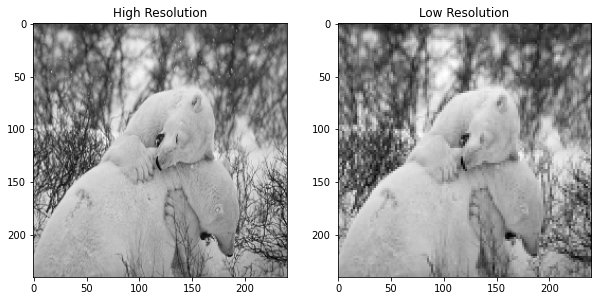

In [96]:
from matplotlib import pyplot as plt

f = plt.figure()
f.set_size_inches(10,10)

f1=f.add_subplot(1,2, 1)
plt.imshow(train[0][:,:,0],cmap='gray')
f1.title.set_text('High Resolution')
f2=f.add_subplot(1,2, 2)
plt.imshow(low_train[0][:,:,0], cmap='gray')
f2.title.set_text('Low Resolution')
plt.show(block=True)

In [97]:
a=train-low_train

In [98]:
a[0][0,8,0]

0.01470588235294118

We use the autoencoder model to train on our training images and validate on our validation images.

This autoencoder model is inspired from the following code with little modification (https://towardsdatascience.com/image-super-resolution-using-convolution-neural-networks-and-auto-encoders-28c9eceadf90)

In [99]:
Input_img = Input(shape=(im_size,im_size,1))  
    
#encoding architecture
x1 = Conv2D(64, (3, 3),kernel_initializer="glorot_uniform", activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(Input_img)
x2 = Conv2D(64, (3, 3), kernel_initializer="glorot_uniform",activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x1)
x3 = MaxPool2D(padding='same')(x2)
x4 = Conv2D(128, (3, 3), kernel_initializer="glorot_uniform",activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x3)
x5 = Conv2D(128, (3, 3), kernel_initializer="glorot_uniform",activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x4)
x6 = MaxPool2D(padding='same')(x5)
encoded = Conv2D(256, (3, 3), kernel_initializer="glorot_uniform", activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x6)
# decoding architecture
x7 = UpSampling2D()(encoded)
x8 = Conv2D(128, (3, 3), kernel_initializer="glorot_uniform", activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x7)
x9 = Conv2D(128, (3, 3), kernel_initializer="glorot_uniform", activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x8)
x10 = Add()([x5, x9])
x11 = UpSampling2D()(x10)
x12 = Conv2D(64, (3, 3),kernel_initializer="glorot_uniform",  activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x11)
x13 = Conv2D(64, (3, 3), kernel_initializer="glorot_uniform", activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x12)
x14 = Add()([x2, x13])

decoded = Conv2D(3, (3, 3),kernel_initializer="glorot_uniform",  padding='same',activation='relu', kernel_regularizer=regularizers.l1(10e-10))(x14)
autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 240, 240, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_40 (Conv2D)             (None, 240, 240, 64  640         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_41 (Conv2D)             (None, 240, 240, 64  36928       ['conv2d_40[0][0]']              
                                )                                                           

In [100]:
early_stopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

In [101]:
history = autoencoder.fit(low_train,train,
            epochs=100,
            validation_data=(low_valid, val),
            callbacks=[early_stopper]
            )


Epoch 1/100
7/7 [==============================] - 8s 897ms/step - loss: 0.1699 - val_loss: 0.1094
Epoch 2/100
7/7 [==============================] - 6s 859ms/step - loss: 0.0587 - val_loss: 0.0100
Epoch 3/100
7/7 [==============================] - 6s 859ms/step - loss: 0.0126 - val_loss: 0.0106
Epoch 4/100
7/7 [==============================] - 6s 866ms/step - loss: 0.0089 - val_loss: 0.0076
Epoch 5/100
7/7 [==============================] - 6s 871ms/step - loss: 0.0064 - val_loss: 0.0055
Epoch 6/100
7/7 [==============================] - 6s 878ms/step - loss: 0.0050 - val_loss: 0.0046
Epoch 7/100
7/7 [==============================] - 6s 887ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 8/100
7/7 [==============================] - 6s 891ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 9/100
7/7 [==============================] - 6s 887ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 10/100
7/7 [==============================] - 6s 882ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 11/

In [102]:
loss_score = autoencoder.evaluate(low_valid, val)


4/4 [==============================] - 1s 204ms/step - loss: 0.0019


The validation loss with interpolation method (Inter Area) and Scaling Factor (2x) is 0.005

In [103]:
print('validation Loss', loss_score) 

validation Loss 0.001941370777785778


The validation Accuracy with interpolation method (Inter Area) and Scaling Factor (2x) is 99.47

In [104]:
1 - 0.005269800312817097

0.9947301996871829

In [105]:
print('validation accuracy', (1-loss_score)*100)

validation accuracy 99.80586292222142


Plotting the training and validation loss

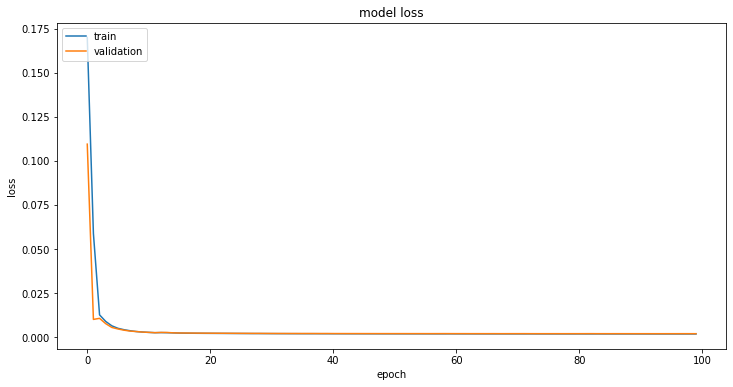

In [106]:

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



Loading the test dataset.

We use the SET5 Dataset for testing purpose.

Set5 dataset consists of 5 images.

In [107]:
import os
import copy
from tqdm import tqdm
folder='Set5/'

test=[]
arr=[]
names=[]
with tqdm(total=len(os.listdir(path+"images/"+folder))) as pbar:
  for img in os.listdir(path+"images/"+folder):
    names.append(img)
    im=cv2.imread(path+"images/"+folder+"/"+img,0)
    try:
      im=cv2.resize(im,(im_size,im_size))
      im=im/255.0
      arr.append(im)
      pbar.update(1)
    except Exception as e:
      print("EXC: ", e)
      pass
    test=np.array(arr)
    pbar.update(1)

test.shape

10it [00:00, 298.04it/s]             


(5, 240, 240)

In [108]:
test=np.expand_dims(test,axis=3)

Passing the test images through low resolutin function to lower the testing images resolution

In [109]:
low_test=Convert_to_lower(test,"INTER_AREA",2)
low_test.shape

(5, 240, 240, 1)

Predicting the outputs (low resolution-->high resolution conversion)

In [110]:
preds=autoencoder.predict(low_test)


We calculate the Mean Squared Error of the High Resolution and Our Reconstructed Images.
AND
Mean Squared Error of the High Resolution Images and Degraded Images.

If the MSE decreases, this means our model is working well.

In [111]:
import tensorflow as tf
def Mean_Square_error(test,preds,low_test):
  mse = tf.keras.losses.MeanSquaredError()
  for i,pred in enumerate(preds):
    print("MSE of High Resolution and Our Reconstructed Image")
    print(names[i],mse(test[i], pred).numpy())
    print("MSE of High Resolution and Degraded Image")
    print(names[i],mse(low_test[i], test[i]).numpy())
    print("**************************************")
  return

In [112]:
Mean_Square_error(test,preds,low_test)

MSE of High Resolution and Our Reconstructed Image
bird.png 0.00019122224
MSE of High Resolution and Degraded Image
bird.png 0.00081395183224231
**************************************
MSE of High Resolution and Our Reconstructed Image
woman.png 0.00042155955
MSE of High Resolution and Degraded Image
woman.png 0.0015356173971667886
**************************************
MSE of High Resolution and Our Reconstructed Image
baby.png 0.00057653006
MSE of High Resolution and Degraded Image
baby.png 0.0012631375575438142
**************************************
MSE of High Resolution and Our Reconstructed Image
butterfly.png 0.00065757585
MSE of High Resolution and Degraded Image
butterfly.png 0.003629980841651559
**************************************
MSE of High Resolution and Our Reconstructed Image
head.png 0.0002068189
MSE of High Resolution and Degraded Image
head.png 0.00039341370575129986
**************************************


Visualizing the Degraded, Reconstructed and Original High Resolution Images.

In [113]:
def show_images (no):
    # no = number of image in test
    f = plt.figure()
    f.set_size_inches(15, 15)

    f.add_subplot(1,3, 1)
    plt.imshow(low_test[no][:,:,0],cmap='gray')
    plt.title('Degraded')

    f.add_subplot(1,3, 2)
    plt.imshow(preds[no])
    plt.title("Reconstructed")


    f.add_subplot(1,3, 3)
    plt.imshow(test[no][:,:,0],cmap='gray')
    plt.title('Original')

    plt.show()
    return()



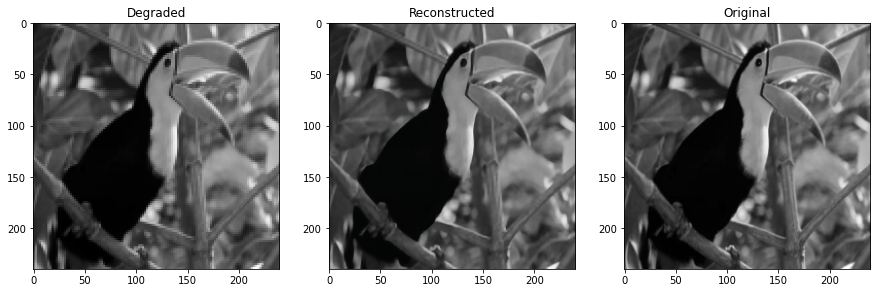

()

In [114]:
show_images(0)

We define function to calculate the PNSR 

In [115]:
def PSNR(y_true,y_pred):
    mse=tf.reduce_mean( (y_true - y_pred) ** 2)
    return 20 * log10(1 / (mse ** 0.5))

def log10(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator

We calculate the PNSR of the Degraded and High Resolution and Compare it with the Reconstructed and High Resolution Images.

If the PNSR of Reconstructed Images if greater then the Degraded, this means our model is providing good results.

In [116]:

def Calculate_PNSR(test,preds,low_test):
    for i,pred in enumerate(preds):
      print("PNSR of Degraded and High Resolution")
      print(names[i],PSNR(low_test[i],test[i]))
      print("PNSR of Reconstructed and High Resolution")
      print(names[i],PSNR(pred,test[i]))
      print("************************")
    return




In [117]:
Calculate_PNSR(test,preds,low_test)

PNSR of Degraded and High Resolution
bird.png tf.Tensor(30.894012949566537, shape=(), dtype=float64)
PNSR of Reconstructed and High Resolution
bird.png tf.Tensor(37.18461654773166, shape=(), dtype=float64)
************************
PNSR of Degraded and High Resolution
woman.png tf.Tensor(28.137169630738658, shape=(), dtype=float64)
PNSR of Reconstructed and High Resolution
woman.png tf.Tensor(33.75141085657415, shape=(), dtype=float64)
************************
PNSR of Degraded and High Resolution
baby.png tf.Tensor(28.985493684066334, shape=(), dtype=float64)
PNSR of Reconstructed and High Resolution
baby.png tf.Tensor(32.39178061360354, shape=(), dtype=float64)
************************
PNSR of Degraded and High Resolution
butterfly.png tf.Tensor(24.400956572927175, shape=(), dtype=float64)
PNSR of Reconstructed and High Resolution
butterfly.png tf.Tensor(31.82054146597135, shape=(), dtype=float64)
************************
PNSR of Degraded and High Resolution
head.png tf.Tensor(34.05150

# SECTION 2 = interpolation function= **Inter_Area** but scaling factor to **4x**


###### NOTE: Reload the training and validation, testing data again and expand their dimensions and then run the following cells. 

In [130]:
scale=4
Type="INTER_AREA"
low_train=Convert_to_lower(train,Type,scale)
low_valid=Convert_to_lower(val,Type,scale)
low_test=Convert_to_lower(test,Type,scale)

In [131]:
history = autoencoder.fit(low_train,train,
            epochs=100,
            validation_data=(low_valid, val),
            callbacks=[early_stopper]
            )

Epoch 1/100
7/7 [==============================] - 6s 863ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 2/100
7/7 [==============================] - 6s 863ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch 3/100
7/7 [==============================] - 6s 865ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 4/100
7/7 [==============================] - 6s 874ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 5/100
7/7 [==============================] - 6s 880ms/step - loss: 0.0047 - val_loss: 0.0048
Epoch 6/100
7/7 [==============================] - 6s 886ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 7/100
7/7 [==============================] - 6s 886ms/step - loss: 0.0045 - val_loss: 0.0047
Epoch 8/100
7/7 [==============================] - 6s 879ms/step - loss: 0.0045 - val_loss: 0.0046
Epoch 9/100
7/7 [==============================] - 6s 873ms/step - loss: 0.0045 - val_loss: 0.0046
Epoch 10/100
7/7 [==============================] - 6s 871ms/step - loss: 0.0044 - val_loss: 0.0046
Epoch 11/

In [132]:
preds=autoencoder.predict(low_test)

MSE with interpolation Inter Area and Scaling 4x 

In [133]:
Mean_Square_error(test,preds,low_test)


MSE of High Resolution and Our Reconstructed Image
bird.png 0.0010435993
MSE of High Resolution and Degraded Image
bird.png 0.002713601803407073
**************************************
MSE of High Resolution and Our Reconstructed Image
woman.png 0.0021746075
MSE of High Resolution and Degraded Image
woman.png 0.004966190550476313
**************************************
MSE of High Resolution and Our Reconstructed Image
baby.png 0.0018323208
MSE of High Resolution and Degraded Image
baby.png 0.003646132070571184
**************************************
MSE of High Resolution and Our Reconstructed Image
butterfly.png 0.003854715
MSE of High Resolution and Degraded Image
butterfly.png 0.0117030693218112
**************************************
MSE of High Resolution and Our Reconstructed Image
head.png 0.00058086554
MSE of High Resolution and Degraded Image
head.png 0.0010163403348997235
**************************************


Visualize the results

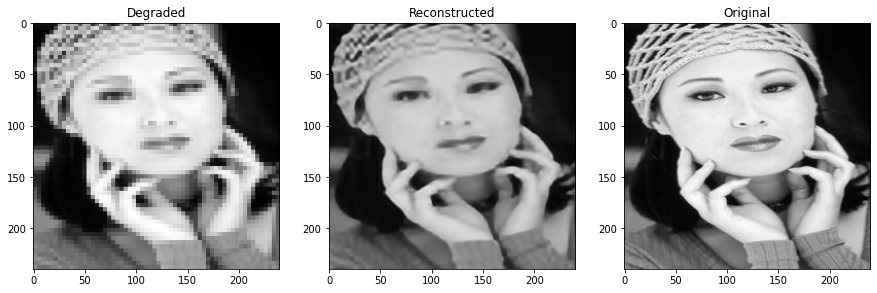

()

In [134]:
show_images(1)


PNSR after interpolation is Inter Area and Scaling is 4x

In [135]:
Calculate_PNSR(test,preds,low_test)

PNSR of Degraded and High Resolution
bird.png tf.Tensor(25.664539150287922, shape=(), dtype=float64)
PNSR of Reconstructed and High Resolution
bird.png tf.Tensor(29.814662021233755, shape=(), dtype=float64)
************************
PNSR of Degraded and High Resolution
woman.png tf.Tensor(23.03976614601136, shape=(), dtype=float64)
PNSR of Reconstructed and High Resolution
woman.png tf.Tensor(26.626191300705422, shape=(), dtype=float64)
************************
PNSR of Degraded and High Resolution
baby.png tf.Tensor(24.381676071956697, shape=(), dtype=float64)
PNSR of Reconstructed and High Resolution
baby.png tf.Tensor(27.369984877531827, shape=(), dtype=float64)
************************
PNSR of Degraded and High Resolution
butterfly.png tf.Tensor(19.317002189807923, shape=(), dtype=float64)
PNSR of Reconstructed and High Resolution
butterfly.png tf.Tensor(24.14007754368944, shape=(), dtype=float64)
************************
PNSR of Degraded and High Resolution
head.png tf.Tensor(29.929

# Section 3: interpolation function= **Inter Nearest** and scaling factor is **2x**
##### NOTE: Reload the training and validation, testing data again and expand their dimensions and then run the following cells.

In [136]:
scale=2
Type="INTER_NEAREST"
low_train=Convert_to_lower(train,Type,scale)
low_valid=Convert_to_lower(val,Type,scale)
low_test=Convert_to_lower(test,Type,scale)


In [137]:
history = autoencoder.fit(low_train,train,
            epochs=100,
            validation_data=(low_valid, val),
            callbacks=[early_stopper]
            )

Epoch 1/100
7/7 [==============================] - 6s 882ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 2/100
7/7 [==============================] - 6s 871ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 3/100
7/7 [==============================] - 6s 873ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 4/100
7/7 [==============================] - 6s 870ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 5/100
7/7 [==============================] - 6s 872ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 6/100
7/7 [==============================] - 6s 873ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 7/100
7/7 [==============================] - 6s 872ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 8/100
7/7 [==============================] - 6s 870ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 9/100
7/7 [==============================] - 6s 872ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 10/100
7/7 [==============================] - 6s 869ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 11/

In [138]:
preds=autoencoder.predict(low_test)

MSE with interpolation Inter Nearest and Scaling 2x

In [139]:
Mean_Square_error(test,preds,low_test)

MSE of High Resolution and Our Reconstructed Image
bird.png 0.00026373295
MSE of High Resolution and Degraded Image
bird.png 0.001641443814150989
**************************************
MSE of High Resolution and Our Reconstructed Image
woman.png 0.0006148786
MSE of High Resolution and Degraded Image
woman.png 0.0031626527197659016
**************************************
MSE of High Resolution and Our Reconstructed Image
baby.png 0.00079075125
MSE of High Resolution and Degraded Image
baby.png 0.002544088289141655
**************************************
MSE of High Resolution and Our Reconstructed Image
butterfly.png 0.0010726824
MSE of High Resolution and Degraded Image
butterfly.png 0.006460806354880333
**************************************
MSE of High Resolution and Our Reconstructed Image
head.png 0.00027107805
MSE of High Resolution and Degraded Image
head.png 0.0008107475005090237
**************************************


Visualize the results

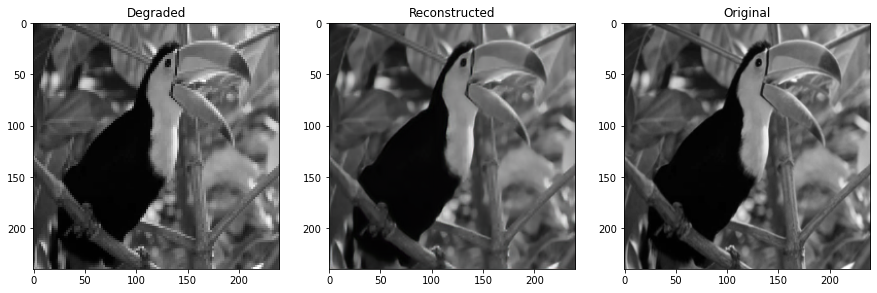

()

In [140]:
show_images(0)

    

PNSR after interpolation is Inter Nearest and Scaling is 2x

In [141]:
Calculate_PNSR(test,preds,low_test)

PNSR of Degraded and High Resolution
bird.png tf.Tensor(27.84774000929626, shape=(), dtype=float64)
PNSR of Reconstructed and High Resolution
bird.png tf.Tensor(35.78835639177767, shape=(), dtype=float64)
************************
PNSR of Degraded and High Resolution
woman.png tf.Tensor(24.999484939790246, shape=(), dtype=float64)
PNSR of Reconstructed and High Resolution
woman.png tf.Tensor(32.112106428202594, shape=(), dtype=float64)
************************
PNSR of Degraded and High Resolution
baby.png tf.Tensor(25.944677774821677, shape=(), dtype=float64)
PNSR of Reconstructed and High Resolution
baby.png tf.Tensor(31.019600963289466, shape=(), dtype=float64)
************************
PNSR of Degraded and High Resolution
butterfly.png tf.Tensor(21.89713267554503, shape=(), dtype=float64)
PNSR of Reconstructed and High Resolution
butterfly.png tf.Tensor(29.6952881983144, shape=(), dtype=float64)
************************
PNSR of Degraded and High Resolution
head.png tf.Tensor(30.911143

# Section 4: Interpolation function= **Inter_Nearest** and scaling factor to **4x**
##### NOTE: Reload the training and validation, testing data again and expand their dimensions and then run the following cells.

In [142]:
scale=4
Type="INTER_NEAREST"
low_train=Convert_to_lower(train,Type,scale)
low_valid=Convert_to_lower(val,Type,scale)
low_test=Convert_to_lower(test,Type,scale)

In [143]:
history = autoencoder.fit(low_train,train,
            epochs=100,
            validation_data=(low_valid, val),
            callbacks=[early_stopper]
            )

Epoch 1/100
7/7 [==============================] - 6s 870ms/step - loss: 0.0081 - val_loss: 0.0075
Epoch 2/100
7/7 [==============================] - 6s 868ms/step - loss: 0.0072 - val_loss: 0.0069
Epoch 3/100
7/7 [==============================] - 6s 875ms/step - loss: 0.0065 - val_loss: 0.0065
Epoch 4/100
7/7 [==============================] - 6s 880ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 5/100
7/7 [==============================] - 6s 887ms/step - loss: 0.0062 - val_loss: 0.0064
Epoch 6/100
7/7 [==============================] - 6s 889ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 7/100
7/7 [==============================] - 6s 890ms/step - loss: 0.0061 - val_loss: 0.0063
Epoch 8/100
7/7 [==============================] - 6s 881ms/step - loss: 0.0061 - val_loss: 0.0063
Epoch 9/100
7/7 [==============================] - 6s 876ms/step - loss: 0.0061 - val_loss: 0.0062
Epoch 10/100
7/7 [==============================] - 6s 876ms/step - loss: 0.0061 - val_loss: 0.0062
Epoch 11/

In [144]:
preds=autoencoder.predict(low_test)

MSE after interpolation is Inter Nearest and Scaling is 4x

MSE of High Resolution and Our Reconstructed Image
bird.png 0.0019385568
MSE of High Resolution and Degraded Image
bird.png 0.007143158465623856
**************************************
MSE of High Resolution and Our Reconstructed Image
woman.png 0.0032590553
MSE of High Resolution and Degraded Image
woman.png 0.012492876499891281
**************************************
MSE of High Resolution and Our Reconstructed Image
baby.png 0.0026273
MSE of High Resolution and Degraded Image
baby.png 0.009184923022985458
**************************************
MSE of High Resolution and Our Reconstructed Image
butterfly.png 0.0075789895
MSE of High Resolution and Degraded Image
butterfly.png 0.025532584637403488
**************************************
MSE of High Resolution and Our Reconstructed Image
head.png 0.00089215714
MSE of High Resolution and Degraded Image
head.png 0.0025641892571002245
**************************************


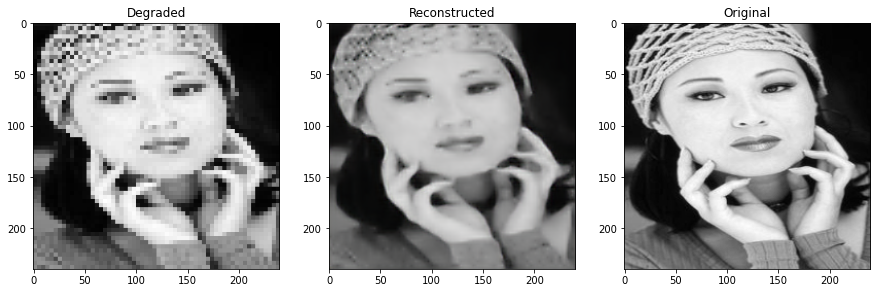

()

In [145]:
Mean_Square_error(test,preds,low_test)
show_images(1)

PNSR after interpolation is Inter Nearest and Scaling is 4x

In [146]:
Calculate_PNSR(test,preds,low_test)

PNSR of Degraded and High Resolution
bird.png tf.Tensor(21.46109722469566, shape=(), dtype=float64)
PNSR of Reconstructed and High Resolution
bird.png tf.Tensor(27.125215196589203, shape=(), dtype=float64)
************************
PNSR of Degraded and High Resolution
woman.png tf.Tensor(19.033375658853174, shape=(), dtype=float64)
PNSR of Reconstructed and High Resolution
woman.png tf.Tensor(24.869082787201524, shape=(), dtype=float64)
************************
PNSR of Degraded and High Resolution
baby.png tf.Tensor(20.36924442306857, shape=(), dtype=float64)
PNSR of Reconstructed and High Resolution
baby.png tf.Tensor(25.804903501807672, shape=(), dtype=float64)
************************
PNSR of Degraded and High Resolution
butterfly.png tf.Tensor(15.929052143545992, shape=(), dtype=float64)
PNSR of Reconstructed and High Resolution
butterfly.png tf.Tensor(21.203887077405703, shape=(), dtype=float64)
************************
PNSR of Degraded and High Resolution
head.png tf.Tensor(25.910

# Section 5: Interpolation function= **Inter_Cubic** and  scaling factor is **2x**
##### NOTE: Reload the training and validation, testing data again and expand their dimensions and then run the following cells.

In [147]:
scale=2
Type="INTER_CUBIC"
low_train=Convert_to_lower(train,Type,scale)
low_valid=Convert_to_lower(val,Type,scale)
low_test=Convert_to_lower(test,Type,scale)

In [148]:
history = autoencoder.fit(low_train,train,
            epochs=100,
            validation_data=(low_valid, val),
            callbacks=[early_stopper]
            )

Epoch 1/100
7/7 [==============================] - 6s 883ms/step - loss: 0.0045 - val_loss: 0.0035
Epoch 2/100
7/7 [==============================] - 6s 870ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 3/100
7/7 [==============================] - 6s 872ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 4/100
7/7 [==============================] - 6s 871ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 5/100
7/7 [==============================] - 6s 873ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 6/100
7/7 [==============================] - 6s 873ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 7/100
7/7 [==============================] - 6s 872ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 8/100
7/7 [==============================] - 6s 873ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 9/100
7/7 [==============================] - 6s 870ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 10/100
7/7 [==============================] - 6s 871ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 11/

In [149]:
preds=autoencoder.predict(low_test)

MSE with interpolation Inter Cubic and Scaling 2x

In [150]:
Mean_Square_error(test,preds,low_test)

MSE of High Resolution and Our Reconstructed Image
bird.png 0.00019593036
MSE of High Resolution and Degraded Image
bird.png 0.0002369629655731842
**************************************
MSE of High Resolution and Our Reconstructed Image
woman.png 0.00045245263
MSE of High Resolution and Degraded Image
woman.png 0.0005843155086040497
**************************************
MSE of High Resolution and Our Reconstructed Image
baby.png 0.000611481
MSE of High Resolution and Degraded Image
baby.png 0.0006634608726017177
**************************************
MSE of High Resolution and Our Reconstructed Image
butterfly.png 0.0007351825
MSE of High Resolution and Degraded Image
butterfly.png 0.0012587163364514709
**************************************
MSE of High Resolution and Our Reconstructed Image
head.png 0.00021580722
MSE of High Resolution and Degraded Image
head.png 0.00022209617600310594
**************************************


Visualize the results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


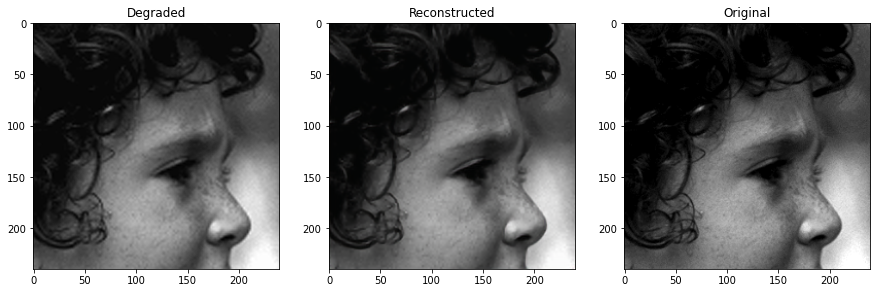

()

In [151]:
show_images(4)

PNSR with interpolation Inter Cubic and Scaling 2x

In [152]:
Calculate_PNSR(test,preds,low_test)

PNSR of Degraded and High Resolution
bird.png tf.Tensor(36.2531949326721, shape=(), dtype=float64)
PNSR of Reconstructed and High Resolution
bird.png tf.Tensor(37.07898221794938, shape=(), dtype=float64)
************************
PNSR of Degraded and High Resolution
woman.png tf.Tensor(32.333525637873, shape=(), dtype=float64)
PNSR of Reconstructed and High Resolution
woman.png tf.Tensor(33.44426894247824, shape=(), dtype=float64)
************************
PNSR of Degraded and High Resolution
baby.png tf.Tensor(31.78184703837859, shape=(), dtype=float64)
PNSR of Reconstructed and High Resolution
baby.png tf.Tensor(32.136170533908974, shape=(), dtype=float64)
************************
PNSR of Degraded and High Resolution
butterfly.png tf.Tensor(29.00072126445743, shape=(), dtype=float64)
PNSR of Reconstructed and High Resolution
butterfly.png tf.Tensor(31.33604860868296, shape=(), dtype=float64)
************************
PNSR of Degraded and High Resolution
head.png tf.Tensor(36.53458906750

# Section 6: Interpolation function= **Inter_Cubic** but scaling factor is **4x**
##### NOTE: Reload the training and validation, testing data again and expand their dimensions and then run the following cells

In [153]:
scale=4
Type="INTER_CUBIC"
low_train=Convert_to_lower(train,Type,scale)
low_valid=Convert_to_lower(val,Type,scale)
low_test=Convert_to_lower(test,Type,scale)

In [154]:
history = autoencoder.fit(low_train,train,
            epochs=100,
            validation_data=(low_valid, val),
            callbacks=[early_stopper]
            )

Epoch 1/100
7/7 [==============================] - 6s 884ms/step - loss: 0.0061 - val_loss: 0.0063
Epoch 2/100
7/7 [==============================] - 6s 871ms/step - loss: 0.0061 - val_loss: 0.0061
Epoch 3/100
7/7 [==============================] - 6s 873ms/step - loss: 0.0059 - val_loss: 0.0060
Epoch 4/100
7/7 [==============================] - 6s 872ms/step - loss: 0.0058 - val_loss: 0.0059
Epoch 5/100
7/7 [==============================] - 6s 870ms/step - loss: 0.0057 - val_loss: 0.0059
Epoch 6/100
7/7 [==============================] - 6s 871ms/step - loss: 0.0057 - val_loss: 0.0059
Epoch 7/100
7/7 [==============================] - 6s 871ms/step - loss: 0.0057 - val_loss: 0.0059
Epoch 8/100
7/7 [==============================] - 6s 872ms/step - loss: 0.0057 - val_loss: 0.0058
Epoch 9/100
7/7 [==============================] - 6s 873ms/step - loss: 0.0057 - val_loss: 0.0058
Epoch 10/100
7/7 [==============================] - 6s 874ms/step - loss: 0.0056 - val_loss: 0.0058
Epoch 11/

In [155]:
preds=autoencoder.predict(low_test)

MSE with interpolation Inter Cubic and Scaling 4x

In [156]:
Mean_Square_error(test,preds,low_test)

MSE of High Resolution and Our Reconstructed Image
bird.png 0.0017547695
MSE of High Resolution and Degraded Image
bird.png 0.0017857631901279092
**************************************
MSE of High Resolution and Our Reconstructed Image
woman.png 0.0033426476
MSE of High Resolution and Degraded Image
woman.png 0.003642159514129162
**************************************
MSE of High Resolution and Our Reconstructed Image
baby.png 0.002465992
MSE of High Resolution and Degraded Image
baby.png 0.0031677852384746075
**************************************
MSE of High Resolution and Our Reconstructed Image
butterfly.png 0.0078070164
MSE of High Resolution and Degraded Image
butterfly.png 0.00817376933991909
**************************************
MSE of High Resolution and Our Reconstructed Image
head.png 0.000797029
MSE of High Resolution and Degraded Image
head.png 0.0008803275995887816
**************************************


Visualize the results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


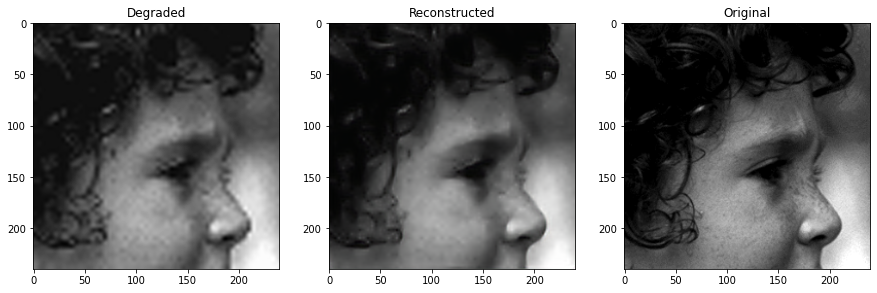

()

In [157]:
show_images(4)

PNSR after interpolation is Inter Cubic and Scaling is 4x

In [158]:
Calculate_PNSR(test,preds,low_test)

PNSR of Degraded and High Resolution
bird.png tf.Tensor(27.48176114468121, shape=(), dtype=float64)
PNSR of Reconstructed and High Resolution
bird.png tf.Tensor(27.557799483825796, shape=(), dtype=float64)
************************
PNSR of Degraded and High Resolution
woman.png tf.Tensor(24.38641052986104, shape=(), dtype=float64)
PNSR of Reconstructed and High Resolution
woman.png tf.Tensor(24.75909424220636, shape=(), dtype=float64)
************************
PNSR of Degraded and High Resolution
baby.png tf.Tensor(24.992442561237933, shape=(), dtype=float64)
PNSR of Reconstructed and High Resolution
baby.png tf.Tensor(26.08008364912497, shape=(), dtype=float64)
************************
PNSR of Degraded and High Resolution
butterfly.png tf.Tensor(20.87577607519625, shape=(), dtype=float64)
PNSR of Reconstructed and High Resolution
butterfly.png tf.Tensor(21.07514893880367, shape=(), dtype=float64)
************************
PNSR of Degraded and High Resolution
head.png tf.Tensor(30.5535565

# Section 7: Interpolation function = **Inter_Linear** and scaling factor is **2x**
##### NOTE: Reload the training and validation data again and expand their dimensions and then run the following cells.

In [159]:
scale=2
Type="INTER_LINEAR"
low_train=Convert_to_lower(train,Type,scale)
low_valid=Convert_to_lower(val,Type,scale)
low_test=Convert_to_lower(test,Type,scale)

In [160]:
history = autoencoder.fit(low_train,train,
            epochs=100,
            validation_data=(low_valid, val),
            callbacks=[early_stopper]
            )

Epoch 1/100
7/7 [==============================] - 6s 872ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 2/100
7/7 [==============================] - 6s 868ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 3/100
7/7 [==============================] - 6s 874ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 4/100
7/7 [==============================] - 6s 882ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 5/100
7/7 [==============================] - 6s 889ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 6/100
7/7 [==============================] - 6s 893ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 7/100
7/7 [==============================] - 6s 886ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 8/100
7/7 [==============================] - 6s 881ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 9/100
7/7 [==============================] - 6s 876ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 10/100
7/7 [==============================] - 6s 873ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 11/

In [161]:
preds=autoencoder.predict(low_test)

MSE with interpolation Inter Linear and Scaling 2x

In [162]:
Mean_Square_error(test,preds,low_test)

MSE of High Resolution and Our Reconstructed Image
bird.png 0.00017806623
MSE of High Resolution and Degraded Image
bird.png 0.0005072153871878982
**************************************
MSE of High Resolution and Our Reconstructed Image
woman.png 0.00041955002
MSE of High Resolution and Degraded Image
woman.png 0.0010871634585782886
**************************************
MSE of High Resolution and Our Reconstructed Image
baby.png 0.0005615931
MSE of High Resolution and Degraded Image
baby.png 0.000990229076705873
**************************************
MSE of High Resolution and Our Reconstructed Image
butterfly.png 0.0006433954
MSE of High Resolution and Degraded Image
butterfly.png 0.002494639251381159
**************************************
MSE of High Resolution and Our Reconstructed Image
head.png 0.00020090742
MSE of High Resolution and Degraded Image
head.png 0.0003199505736120045
**************************************


Visualize the results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


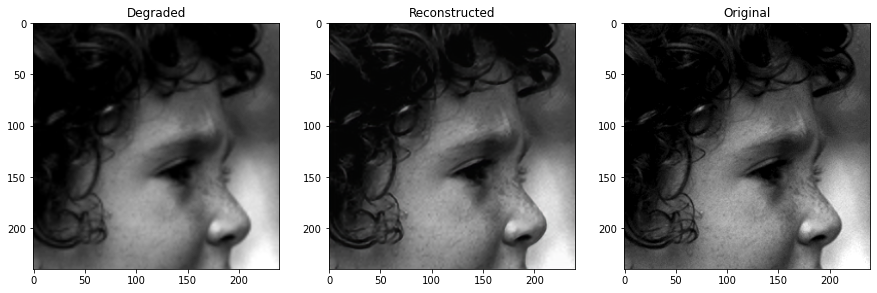

()

In [163]:
show_images(4)

PNSR with interpolation Inter Linear and Scaling 2x

In [164]:
Calculate_PNSR(test,preds,low_test)

PNSR of Degraded and High Resolution
bird.png tf.Tensor(32.948075997761315, shape=(), dtype=float64)
PNSR of Reconstructed and High Resolution
bird.png tf.Tensor(37.494184360471635, shape=(), dtype=float64)
************************
PNSR of Degraded and High Resolution
woman.png tf.Tensor(29.637051794908228, shape=(), dtype=float64)
PNSR of Reconstructed and High Resolution
woman.png tf.Tensor(33.77216282771394, shape=(), dtype=float64)
************************
PNSR of Degraded and High Resolution
baby.png tf.Tensor(30.042643345425546, shape=(), dtype=float64)
PNSR of Reconstructed and High Resolution
baby.png tf.Tensor(32.50578235001207, shape=(), dtype=float64)
************************
PNSR of Degraded and High Resolution
butterfly.png tf.Tensor(26.02992241677579, shape=(), dtype=float64)
PNSR of Reconstructed and High Resolution
butterfly.png tf.Tensor(31.915220561329146, shape=(), dtype=float64)
************************
PNSR of Degraded and High Resolution
head.png tf.Tensor(34.9491

# Section 8 Interpolation function =**Inter Linear** but  scaling factor is **4x**
###### NOTE: Reload the training and validation, testing data again and expand their dimensions and then run the following cells

In [165]:
scale=4
Type="INTER_LINEAR"
low_train=Convert_to_lower(train,Type,scale)
low_valid=Convert_to_lower(val,Type,scale)
low_test=Convert_to_lower(test,Type,scale)

In [166]:
history = autoencoder.fit(low_train,train,
            epochs=100,
            validation_data=(low_valid, val),
            callbacks=[early_stopper]
            )

Epoch 1/100
7/7 [==============================] - 6s 881ms/step - loss: 0.0052 - val_loss: 0.0054
Epoch 2/100
7/7 [==============================] - 6s 870ms/step - loss: 0.0052 - val_loss: 0.0053
Epoch 3/100
7/7 [==============================] - 6s 868ms/step - loss: 0.0051 - val_loss: 0.0053
Epoch 4/100
7/7 [==============================] - 6s 871ms/step - loss: 0.0051 - val_loss: 0.0053
Epoch 5/100
7/7 [==============================] - 6s 871ms/step - loss: 0.0051 - val_loss: 0.0052
Epoch 6/100
7/7 [==============================] - 6s 871ms/step - loss: 0.0051 - val_loss: 0.0052
Epoch 7/100
7/7 [==============================] - 6s 874ms/step - loss: 0.0050 - val_loss: 0.0052
Epoch 8/100
7/7 [==============================] - 6s 876ms/step - loss: 0.0050 - val_loss: 0.0052
Epoch 9/100
7/7 [==============================] - 6s 877ms/step - loss: 0.0050 - val_loss: 0.0052
Epoch 10/100
7/7 [==============================] - 6s 879ms/step - loss: 0.0050 - val_loss: 0.0051
Epoch 11/

In [167]:
preds=autoencoder.predict(low_test)

MSE with interpolation Inter Linear and Scaling 4x

In [168]:
Mean_Square_error(test,preds,low_test)

MSE of High Resolution and Our Reconstructed Image
bird.png 0.0015893049
MSE of High Resolution and Degraded Image
bird.png 0.0018364402931183577
**************************************
MSE of High Resolution and Our Reconstructed Image
woman.png 0.002732436
MSE of High Resolution and Degraded Image
woman.png 0.003596013179048896
**************************************
MSE of High Resolution and Our Reconstructed Image
baby.png 0.0023063128
MSE of High Resolution and Degraded Image
baby.png 0.002776399487629533
**************************************
MSE of High Resolution and Our Reconstructed Image
butterfly.png 0.006472042
MSE of High Resolution and Degraded Image
butterfly.png 0.008390354923903942
**************************************
MSE of High Resolution and Our Reconstructed Image
head.png 0.00067425816
MSE of High Resolution and Degraded Image
head.png 0.0007743436726741493
**************************************


Visualize the results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


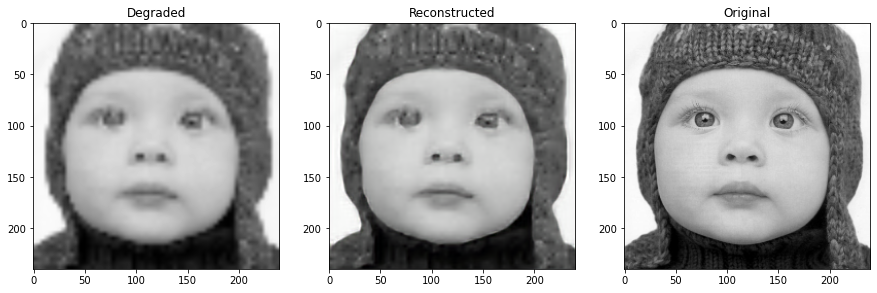

()

In [169]:
show_images(2)

PNSR after interpolation is Inter Linear and Scaling is 4x

In [170]:
Calculate_PNSR(test,preds,low_test)

PNSR of Degraded and High Resolution
bird.png tf.Tensor(27.360231893601696, shape=(), dtype=float64)
PNSR of Reconstructed and High Resolution
bird.png tf.Tensor(27.987928501166614, shape=(), dtype=float64)
************************
PNSR of Degraded and High Resolution
woman.png tf.Tensor(24.441787117557638, shape=(), dtype=float64)
PNSR of Reconstructed and High Resolution
woman.png tf.Tensor(25.63450038694091, shape=(), dtype=float64)
************************
PNSR of Degraded and High Resolution
baby.png tf.Tensor(25.56518026549622, shape=(), dtype=float64)
PNSR of Reconstructed and High Resolution
baby.png tf.Tensor(26.370818311759795, shape=(), dtype=float64)
************************
PNSR of Degraded and High Resolution
butterfly.png tf.Tensor(20.762196966569768, shape=(), dtype=float64)
PNSR of Reconstructed and High Resolution
butterfly.png tf.Tensor(21.88958690542345, shape=(), dtype=float64)
************************
PNSR of Degraded and High Resolution
head.png tf.Tensor(31.1106